<a href="https://colab.research.google.com/github/NLPaladins/rinehartAnalysis_questionAnswering/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Project 3
## Rinehart Analysis Question Answering
**Team**: *Jean Merlet, Konstantinos Georgiou, Matt Lane*

# ------------------------------------------------------------------

## On Google Collab?
- **If yes, run the two cells and press the two buttons below:**
- Otherwise go to "***Import the base Libraries***"

In [1]:
# Import Jupyter Widgets
import pandas as pd
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
# Clone the repository if you're in Google Collab
def clone_project(is_collab: bool = False):
    print("Cloning Project..")
    !git clone https://github.com/NLPaladins/rinehartAnalysis_questionAnswering.git
    print("Project cloned.")
       
print("Clone project?")
print("(If you do this you will ovewrite local changes on other files e.g. configs)")
print("Not needed if you're not on Google Collab")
btn = widgets.Button(description="Yes, clone")
btn.on_click(clone_project)
display(btn)

Clone project?
(If you do this you will ovewrite local changes on other files e.g. configs)
Not needed if you're not on Google Collab


Button(description='Yes, clone', style=ButtonStyle())

In [2]:
# Clone the repository if you're in Google Collab
def change_dir(is_collab: bool = False):
    try:
        print("Changing dir..")
        os.chdir('/content/rinehartAnalysis_questionAnswering')
        print('done')
        print("Current dir:")
        print(os.getcwd())
        print("Dir Contents:")
        print(os.listdir())
        print("\nInstalling Requirements")
        !pip install -r requirements.txt
    except Exception:
        print("Error: Project not cloned")
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

### To commit and push Google Collab notebook to Github
Click **File > Save a copy on Gihtub**

# ------------------------------------------------------------------

# Initializations

## Import the base Libraries

In [3]:
# Imports
%load_ext autoreload
%autoreload 2
from importlib import reload as reload_lib
from typing import *
import os
import re
from pprint import pprint
# Numpy
import numpy as np
# Spacy
from spacy.lang.en import English
# Hugging face
from transformers import pipeline

## Load the YML file

In [4]:
from nlp_libs import Configuration

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [5]:
# The path of configuration and log save path
config_path = "confs/proj_3.yml"
# !cat "$config_path"
# Load the configuratåion
conf = Configuration(config_src=config_path)
# Get the books dict
books_conf = conf.get_config('data_loader')['config']['books']
# print(books.keys())
# pprint(books)  # Pretty print the books dict

2021-11-28 15:41:49 Config       INFO     Configuration file loaded successfully from path: /gpfs/alpine/syb105/proj-shared/Personal/lanemj/nlp/rinehartAnalysis_questionAnswering/confs/proj_3.yml
2021-11-28 15:41:49 Config       INFO     Configuration Tag: proj3


## Setup Logger and Example

In [6]:
from nlp_libs import ColorizedLogger

In [7]:
log_path = "logs/proj_3.log"
# Load and setup logger
logger = ColorizedLogger(logger_name='Notebook', color='cyan')
ColorizedLogger.setup_logger(log_path=log_path, debug=False, clear_log=True)
# Examples
logger.info("Logger Examples:")
logger.nl(num_lines=1) # New lines
logger.warn("Logger Warning underlined", attrs=['underline']) 
# Atrs:  bold, dark, underline, blink, reverse, concealed
logger.error("Logger Error in red&yellow", color="yellow", on_color="on_red")
# Colors: on_grey, on_red, on_green, on_yellow, on_blue, on_magenta, on_cyan, on_white

2021-11-28 15:41:49 FancyLogger  INFO     Logger is set. Log file path: /gpfs/alpine/syb105/proj-shared/Personal/lanemj/nlp/rinehartAnalysis_questionAnswering/logs/proj_3.log
2021-11-28 15:41:49 Notebook     INFO     Logger Examples:

2021-11-28 15:41:49 Notebook     WARNING  Logger Warning underlined
2021-11-28 15:41:49 Notebook     ERROR    Logger Error in red&yellow


# ------------------------------------------------------------------

# Start of Project Code

In [32]:
from nlp_libs import books as proj3_lib
from proj2_nlp_libs import books as proj2_lib
from proj1_nlp_libs import books as proj1_lib
from nlp_libs.books import plotter as pl
import seaborn as sns
from nlp_libs.books.training_question_answer_pairs import *
%matplotlib inline

## Questions and Answers!

### The Circular Staircase

In [9]:
# Load conf
book_meta = books_conf['The_Circular_Staircase']
book = proj3_lib.ProcessedBook(book_meta)
# Get sentences
sentences = book.get_sentences()

## The Basic Model: 

In [11]:
basic_nlp = pipeline('question-answering') 

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


### Section 1: The Protagonist
###### Context: 

In [12]:
protagonist_arrival

'At ten o\'clock the Casanova hack brought up three men. They introduced themselves as the coroner of the county and two detectives from the city. The coroner led the way at once to the locked wing, and with the aid of one of the detectives examined the rooms and the body. The other detective, after a short scrutiny of the dead man, busied himself with the outside of the house. It was only after they had got a fair idea of things as they were that they sent for me. I received them in the living-room, and I had made up my mind exactly what to tell. I had taken the house for the summer, I said, while the Armstrongs were in California. In spite of a rumor among the servants about strange noises-I cited Thomas-nothing had occurred the first two nights. On the third night I believed that some one had been in the house: I had heard a crashing sound, but being alone with one maid had not investigated. The house had been locked in the morning and apparently undisturbed. Then, as clearly as I c

In [13]:
def get_question_df(nlp, questions, actual_answers, context): 
    responses = []
    scores = []
    onlyanswers = list(map(lambda x: x['text'], actual_answers))
    
    for question in questions:
        response = nlp(context=context, question=question)
        responses.append(response['answer'])
        scores.append(response['score'])
        
    df = pd.DataFrame(data={'question':questions, 'actual_answer': onlyanswers, 'model_response': responses, 'score': scores})
    return df

In [14]:
protagonist_df = get_question_df(basic_nlp, protagonist_arrival_questions, protagonist_arrival_answers, protagonist_arrival)

/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


In [15]:
protagonist_df

,question,actual_answer,model_response,score
0,When did the detectives arrive?,ten o'clock,ten o'clock,0.649373
1,What did the coroner do?,examined the rooms and the body,shot him in self-defense,0.544555
2,Where were the detectives received?,in the living-room,living-room,0.404945
3,How did Mr. Armstrong die?,shot,shot,0.751628
4,Who informed Miss Innes about the murder?,Mr. Jarvis,Mr. Jarvis,0.892917
5,Where were the Armstrongs during Summer?,in California,California,0.934917


### Section 2: The Antagonist

In [16]:
antagonist_arrival

'Once in the drawing-room, Gertrude collapsed and went from one fainting spell into another. I had all I could do to keep Liddy from drowning her with cold water, and the maids huddled in a corner, as much use as so many sheep. In a short time, although it seemed hours, a car came rushing up, and Anne Watson, who had waited to dress, opened the door. Three men from the Greenwood Club, in all kinds of costumes, hurried in. I recognized a Mr. Jarvis, but the others were strangers. "What\'s wrong?" the Jarvis man asked-and we made a strange picture, no doubt. "Nobody hurt, is there?" He was looking at Gertrude. "Worse than that, Mr. Jarvis," I said. "I think it is murder." At the word there was a commotion. The cook began to cry, and Mrs. Watson knocked over a chair. The men were visibly impressed. "Not any member of the family?" Mr. Jarvis asked, when he had got his breath. "No," I said; and motioning Liddy to look after Gertrude, I led the way with a lamp to the card-room door. One of t

In [17]:
antagonist_df = get_question_df(basic_nlp, antagonist_arrival_questions, antagonist_arrival_answers, antagonist_arrival)

/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


In [18]:
antagonist_df

,question,actual_answer,model_response,score
0,Who fainted?,Gertrude,Gertrude,0.836888
1,What's wrong?,murder,terrible shock,0.109739
2,Why did Mrs. Watston knock over a chair?,murder,The cook began to cry,0.281203
3,Who opened the door?,Anne Watson,Anne Watson,0.992713
4,Where did Mr. Jarvis come from?,the Greenwood Club,Greenwood Club,0.636472
5,How Many people came to help?,Three,Three,0.666787
6,Who helped Gertrude?,Liddy,Anne Watson,0.906721


### Section 3: The Crime Scene

In [19]:
crime_scene_context

'At three o\'clock in the morning I was roused by a revolver shot. The sound seemed to come from just outside my door. For a moment I could not move. Then-I heard Gertrude stirring in her room, and the next moment she had thrown open the connecting door. "O Aunt Ray! Aunt Ray!" she cried hysterically. "Some one has been killed, killed!" "Thieves," I said shortly. "Thank goodness, there are some men in the house to-night." I was getting into my slippers and a bath-robe, and Gertrude with shaking hands was lighting a lamp. Then we opened the door into the hall, where, crowded on the upper landing of the stairs, the maids, white-faced and trembling, were peering down, headed by Liddy. I was greeted by a series of low screams and questions, and I tried to quiet them. Gertrude had dropped on a chair and sat there limp and shivering. I went at once across the hall to Halsey\'s room and knocked; then I pushed the door open. It was empty; the bed had not been occupied! "He must be in Mr. Baile

In [20]:
crime_scene_df = get_question_df(basic_nlp, crime_scene_questions, crime_scene_answers, crime_scene_context)
crime_scene_df

/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


,question,actual_answer,model_response,score
0,When the did the revolver shoot?,three o'clock in the morning,three o'clock in the morning,0.745478
1,Where was Gertrude?,in her room,her room,0.411023
2,Was Halsey in his room?,It was empty; the bed had not been occupied!,it had not been occupied,0.539794
3,Who was the cook calling?,the Greenwood Club,Greenwood Club,0.659861
4,Where was the man huddled?,"on the floor, face down, with his arms extended",the upper landing of the stairs,0.284429
5,Did they find anyone in Mr. Bailey's room?,it had not been occupied,He must be in Mr. Bailey's room,0.255154


### Section 4: The Evidence

In [21]:
evidence_context

'"Sit down," he said, pushing forward a chair. "There are some things I have to tell you, and, in return, please tell me all you know. Believe me, things always come out. In the first place, Mr. Armstrong was shot from above. The bullet was fired at close range, entered below the shoulder and came out, after passing through the heart, well down the back. In other words, I believe the murderer stood on the stairs and fired down. In the second place, I found on the edge of the billiard-table a charred cigar which had burned itself partly out, and a cigarette which had consumed itself to the cork tip. Neither one had been more than lighted, then put down and forgotten. Have you any idea what it was that made your nephew and Mr. Bailey leave their cigars and their game, take out the automobile without calling the chauffeur, and all this at-let me see-certainly before three o\'clock in the morning?" "I don\'t know," I said; "but depend on it, Mr. Jamieson, Halsey will be back himself to exp

In [22]:
evidence_df = get_question_df(basic_nlp, evidence_questions, evidence_answers, evidence_context)
evidence_df

/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


,question,actual_answer,model_response,score
0,From where was mister armstrong shot?,from above,by the main entrance,0.461368
1,How was the bullet fired?,at close range,at close range,0.375950
2,What was on the billiard-table?,a charred cigar,a charred cigar,0.402333
3,When did Halsey and Mr. Bailey take out the au...,certainly before three o'clock in the morning,before three o'clock in the morning,0.706890
4,When was the murder commmitted?,at three,three,0.709898
5,When did Halsey leave the house?,At a quarter before three,a quarter before three,0.697543
6,Who did Halsey leave with?,Mr. Bailey,my brother,0.517334


### Section 5: The Big Reveal

In [23]:
resolution_context

"On the way across the lawn she was confronted by Arnold, who for some reason was determined to get into the house. He had a golf-stick in his hand, that he had picked up somewhere, and on her refusal he had struck her with it. One hand had been badly cut, and it was that, poisoning having set in, which was killing her. She broke away in a frenzy of rage and fear, and got into the house while Gertrude and Jack Bailey were at the front door. She went up-stairs, hardly knowing what she was doing. Gertrude's door was open, and Halsey's revolver lay there on the bed. She picked it up and turning, ran part way down the circular staircase. She could hear Arnold fumbling at the lock outside. She slipped down quietly and opened the door: he was inside before she had got back to the stairs. It was quite dark, but she could see his white shirt-bosom. From the fourth step she fired. As he fell, somebody in the billiard-room screamed and ran. When the alarm was raised, she had had no time to get u

In [24]:
resolution_df = get_question_df(basic_nlp, resolution_questions, resolution_answers, resolution_context)
resolution_df

/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


,question,actual_answer,model_response,score
0,How did Anne Watson get the gun?,Gertrude's door was open,threw the revolver out of an upper window,0.494896
1,What did Anne Watson do with the gun?,threw the revolver out of an upper window,threw the revolver out of an upper window,0.602842
2,Where was Anne Watson confronted by Arnold?,On the way across the lawn,On the way across the lawn,0.781625
3,What did Arnold strike Anne Watson with?,golf-stick,revolver,0.636938
4,Where did the scream come from?,the billiard-room,billiard-room,0.661554
5,To whom did the weapon belong?,Halsey,the Greenwood Club,0.398191
6,Who did they initially think was the murderer?,Gertrude,Arnold,0.667139


## Specific Questions From a Context Are Cool.... But Can We Explore Everything?

In [60]:
window = 15
top_answers = []
top_scores = []
for question in total_questions: 
    answers = proj3_lib.question_answering.ask_question(question=question,
                                                        sentences=sentences,
                                                        window=window)
    sorted_answers = proj3_lib.question_answering.get_sorted_grouped_answers(answers)
    top_answers.append(sorted_answers[0]['answer'])
    top_scores.append(sorted_answers[0]['mean_score'])

Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.93it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.00it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.01it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.11it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00,  9.96it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.91it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:31<00:00, 10.25it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.19it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.70it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.15it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.89it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.04it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:31<00:00, 10.37it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.16it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:31<00:00, 10.36it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.16it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.16it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.14it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.78it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.92it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.25it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.04it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.66it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.86it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00,  9.96it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.15it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.04it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.02it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00,  9.95it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00,  9.99it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.16it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.19it/s]


Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:32<00:00, 10.02it/s]


In [64]:
allquestions_df_w15 = pd.DataFrame(data  = {'question':total_questions, 'actual ansers': list(map(lambda x: x['text'],total_answers)), 'answers':top_answers, 'score': top_scores })

In [66]:
allquestions_df_w15.to_csv('allquestions_w15', sep='\t')

In [68]:
window = 30
top_answers = []
top_scores = []
for question in total_questions: 
    answers = proj3_lib.question_answering.ask_question(question=question,
                                                        sentences=sentences,
                                                        window=window)
    sorted_answers = proj3_lib.question_answering.get_sorted_grouped_answers(answers)
    top_answers.append(sorted_answers[0]['answer'])
    top_scores.append(sorted_answers[0]['mean_score'])

Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.04it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.19it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.07it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.90it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.98it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:15<00:00, 10.35it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.23it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.67it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.94it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.03it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.21it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.04it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:15<00:00, 10.28it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.01it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.02it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.07it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.76it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.82it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.87it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:17<00:00,  9.59it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.81it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.87it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.00it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.89it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.85it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.87it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.90it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.99it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00, 10.11it/s]


Total number of sentences:  4908


Start index 4890, end index 4913 (23 sents used). Current length of text block: 486: 100%|██████████| 164/164 [00:16<00:00,  9.92it/s]


In [69]:
allquestions_df_w30 = pd.DataFrame(data  = {'question':total_questions, 'actual ansers': list(map(lambda x: x['text'],total_answers)), 'answers':top_answers, 'score': top_scores })

### Make Illustrations

In [44]:
def ask_question_of_whole_book(question, window): 
    answers = proj3_lib.question_answering.ask_question(question=question,
                                                        sentences=sentences,
                                                        window=window)
    sorted_answers = proj3_lib.question_answering.get_sorted_grouped_answers(answers)
    pprint(sorted_answers[:15])

    pal = sns.color_palette("tab10")
    hexes = pal.as_hex()
    rgb = [tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)) for h in hexes]
    pl.plot_scores(answers, title=question, min_score=0.9, base_c=(rgb[0]))

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'Mrs.  Watson', 'mean_score': 0.9603424668312073},
 {'answer': 'Thomas Johnson', 'mean_score': 0.9584291776021322},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9440693855285645},
 {'answer': 'Mr. Trautman', 'mean_score': 0.931241512298584},
 {'answer': 'Mother', 'mean_score': 0.8866367340087891},
 {'answer': 'Mr.  Armstrong', 'mean_score': 0.813378095626831},
 {'answer': 'chimney', 'mean_score': 0.8110072016716003},
 {'answer': 'Anne Watson', 'mean_score': 0.8053592443466187},
 {'answer': 'Mrs. Tate', 'mean_score': 0.805214136838913},
 {'answer': 'Beulah', 'mean_score': 0.7987485527992249},
 {'answer': 'Liddy Allen', 'mean_score': 0.7747461199760437},
 {'answer': 'Louise Armstrong', 'mean_score': 0.7717728272080422},
 {'answer': 'Mr.  Jamieson', 'mean_score': 0.740269124507904},
 {'answer': 'Liddys', 'mean_score': 0.7353972792625427},
 {'answer': 'old Thomas', 'mean_score': 0.7285804450511932}]


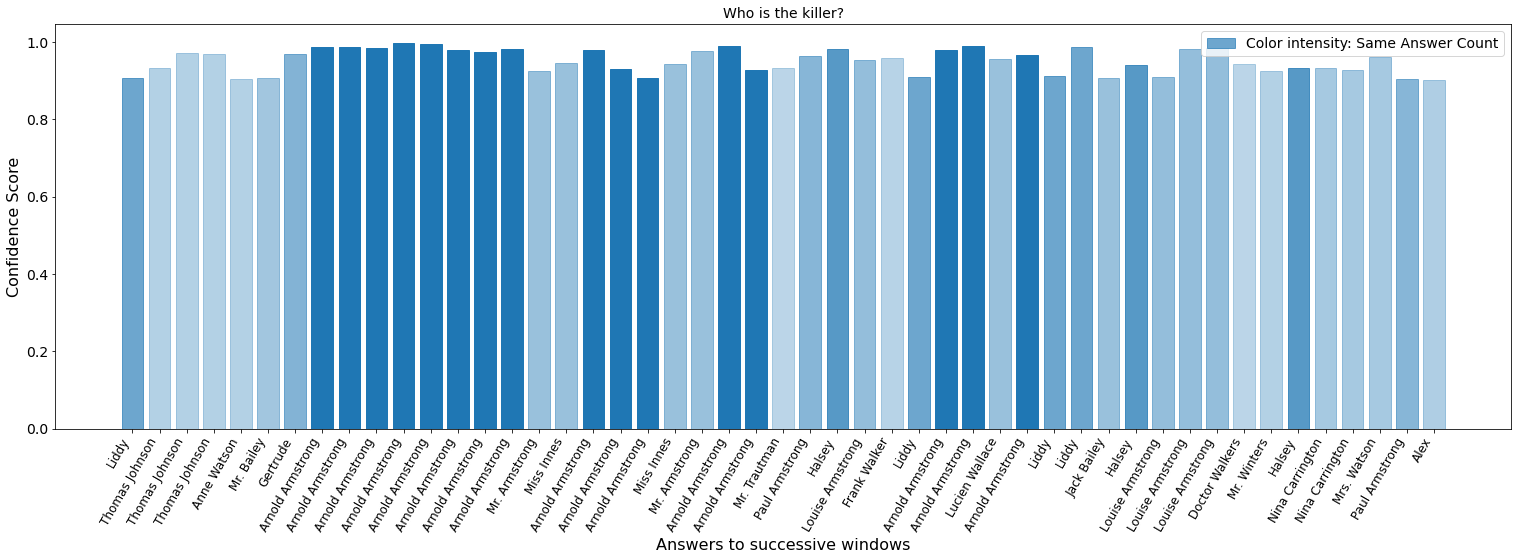

In [45]:
# Ask a question
question = "Who is the killer?"
window = 15
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'Anne Watson', 'mean_score': 0.9848564863204956},
 {'answer': 'Mrs.  Watson', 'mean_score': 0.9778904914855957},
 {'answer': 'Thomas Johnson', 'mean_score': 0.9775369763374329},
 {'answer': 'Doctor  Walker', 'mean_score': 0.964575469493866},
 {'answer': 'Mr.  Burns', 'mean_score': 0.9552402893702189},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9449537992477417},
 {'answer': 'Burns', 'mean_score': 0.9346746504306793},
 {'answer': 'Johnny Sweeny', 'mean_score': 0.9134195446968079},
 {'answer': 'Fanny Armstrong', 'mean_score': 0.9065014123916626},
 {'answer': 'Lucien Wallace', 'mean_score': 0.8931055068969727},
 {'answer': 'Matthew Geist', 'mean_score': 0.890657107035319},
 {'answer': 'Paul  Armstrong', 'mean_score': 0.8872517943382263},
 {'answer': 'Liddys', 'mean_score': 0.8853275775909424},
 {'answer': 'Ella Stewart', 'mean_score': 0.8704534769058228},
 {'answer': 'Arnold', 'mean_score': 0.8607586920261383}]


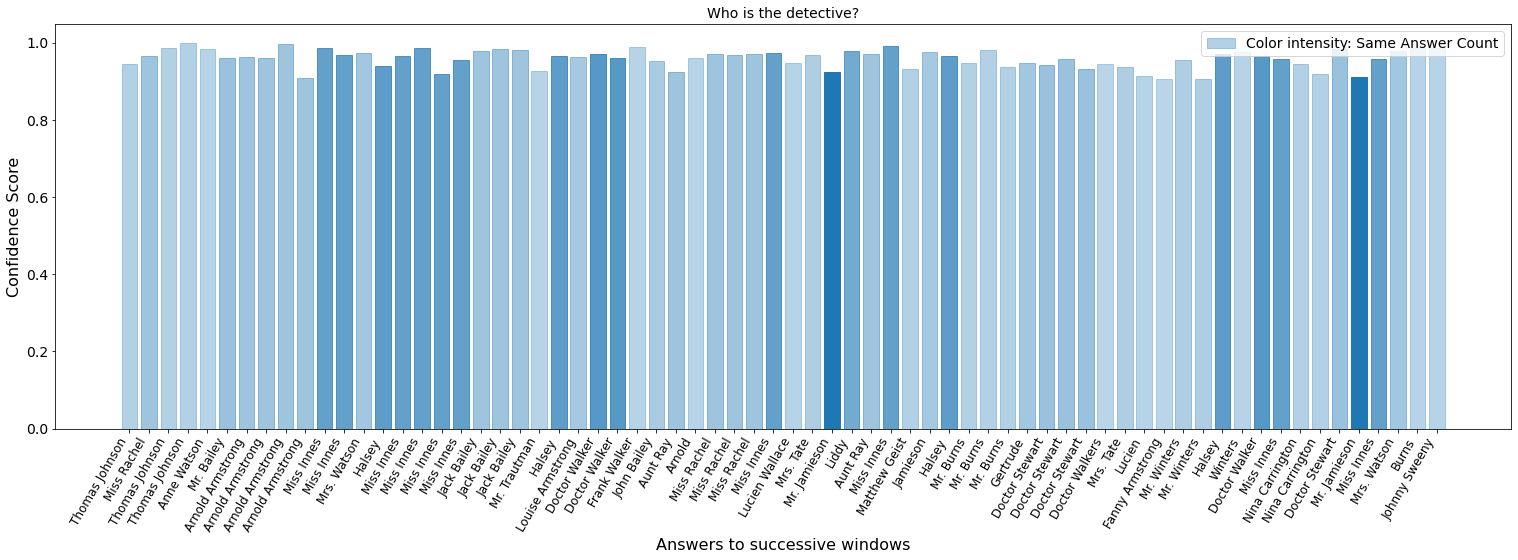

In [46]:
question = "Who is the detective?"
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'Thomas Johnson', 'mean_score': 0.9815708796183268},
 {'answer': 'Mrs.  Watson', 'mean_score': 0.9752088785171509},
 {'answer': 'Burns', 'mean_score': 0.9539628624916077},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9385005831718445},
 {'answer': 'Mr. Aronson', 'mean_score': 0.9381752610206604},
 {'answer': 'Ella Stewart', 'mean_score': 0.938140869140625},
 {'answer': 'Johnny Sweeny', 'mean_score': 0.9357262551784515},
 {'answer': 'Riggs', 'mean_score': 0.9240298271179199},
 {'answer': 'Liddys', 'mean_score': 0.9190152287483215},
 {'answer': 'Miss Armstrong', 'mean_score': 0.9026095867156982},
 {'answer': 'Mr. Trautman', 'mean_score': 0.8971254825592041},
 {'answer': 'Beatrice Fairfax', 'mean_score': 0.8864664435386658},
 {'answer': 'Mr.  Burns', 'mean_score': 0.8770415981610616},
 {'answer': 'Miss Rachel', 'mean_score': 0.8559791412618425},
 {'answer': 'Louise Armstrong', 'mean_score': 0.8554228288786752}]


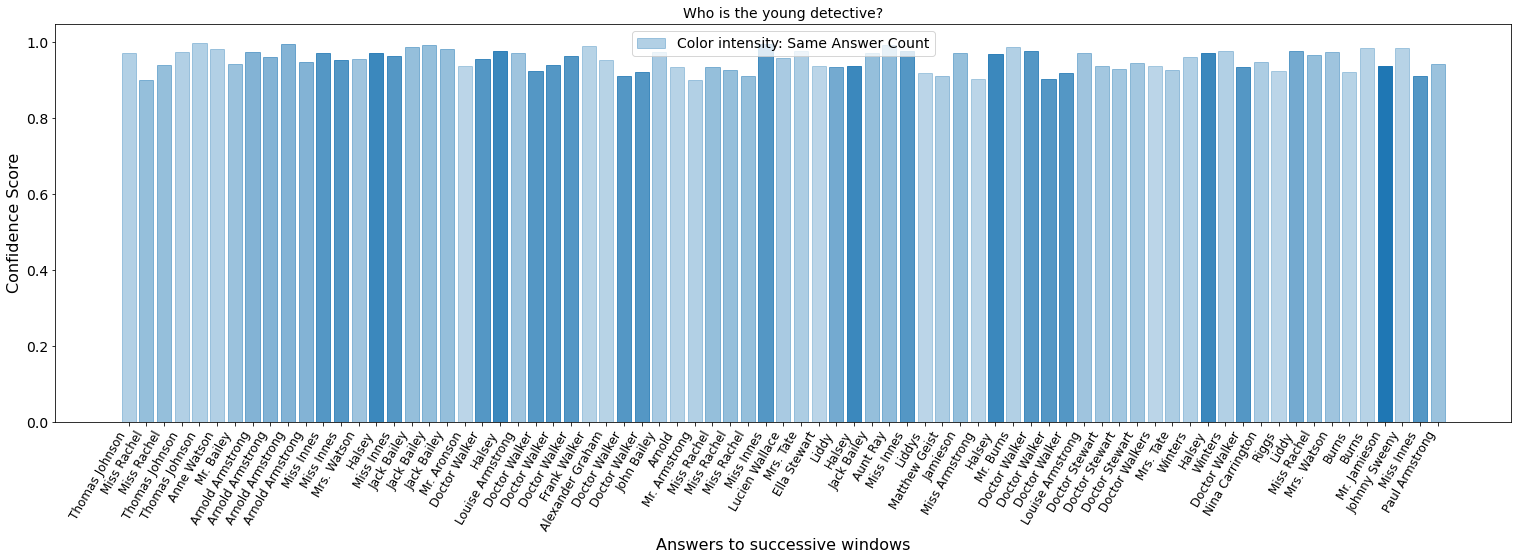

In [54]:
question = "Who is the young detective?"
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'foul  play', 'mean_score': 0.9599116444587708},
 {'answer': 'Paul  Armstrong', 'mean_score': 0.9323129455248514},
 {'answer': 'her brother', 'mean_score': 0.8985849022865295},
 {'answer': 'Mrs. Tate', 'mean_score': 0.8615546822547913},
 {'answer': 'Halsey and Gertrude', 'mean_score': 0.8482629358768463},
 {'answer': 'Mr.  Jamieson', 'mean_score': 0.8236781358718872},
 {'answer': 'The tramp', 'mean_score': 0.8168116807937622},
 {'answer': 'old Thomas', 'mean_score': 0.8100625872612},
 {'answer': 'Arnold Armstrong', 'mean_score': 0.7385418331623077},
 {'answer': 'Mr.  Armstrong', 'mean_score': 0.7371286749839783},
 {'answer': 'Nina Carrington', 'mean_score': 0.7206436395645142},
 {'answer': 'Mary Anne', 'mean_score': 0.7001508623361588},
 {'answer': 'Walker', 'mean_score': 0.6985804438591003},
 {'answer': 'Anne Watson', 'mean_score': 0.6962895393371582},
 {'answer': 'Fanny Armstrong', 'mean_score': 0.693552831808726}]


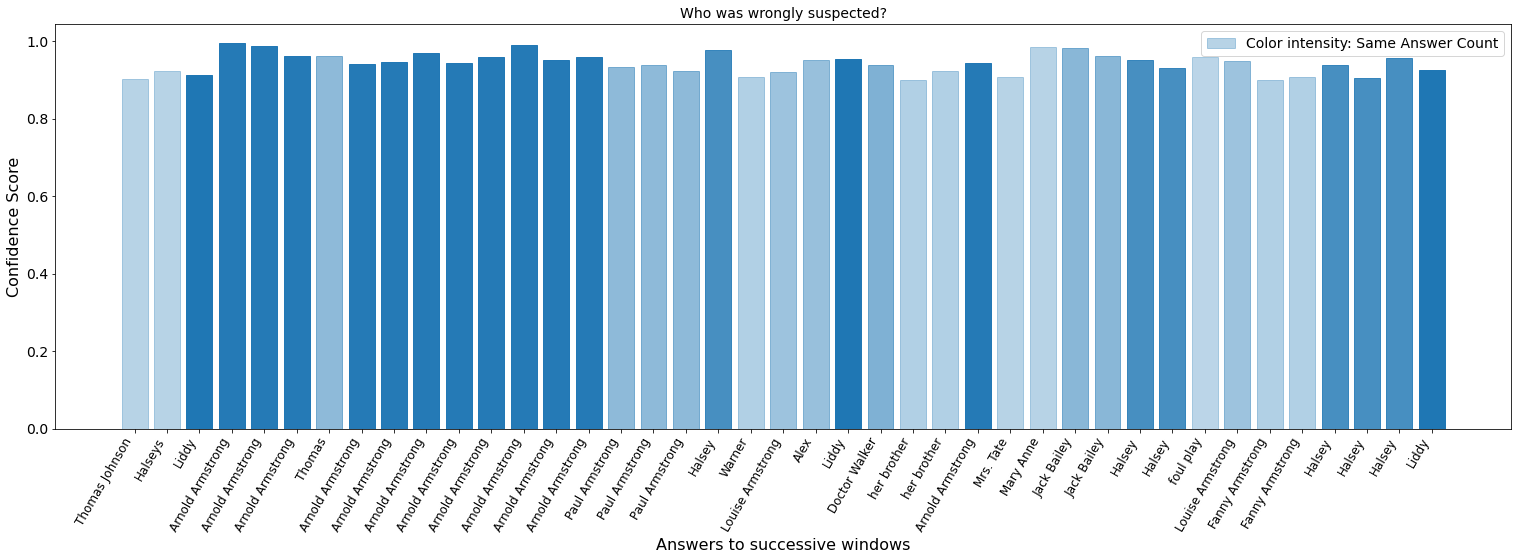

In [47]:
question = "Who was wrongly suspected?"
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'taboret', 'mean_score': 0.874093770980835},
 {'answer': 'Jack  Bailey', 'mean_score': 0.8450756669044495},
 {'answer': 'chimney', 'mean_score': 0.8389401038487753},
 {'answer': 'Halseys revolver', 'mean_score': 0.8274595737457275},
 {'answer': 'Halseys  revolver', 'mean_score': 0.7780899107456207},
 {'answer': 'a golf-stick', 'mean_score': 0.7426087856292725},
 {'answer': 'pipe-smoking', 'mean_score': 0.7223795056343079},
 {'answer': 'Mother', 'mean_score': 0.718846321105957},
 {'answer': 'The bolt', 'mean_score': 0.7172805070877075},
 {'answer': 'thirty-eight  caliber', 'mean_score': 0.7116643786430359},
 {'answer': 'rubber tires', 'mean_score': 0.7070789933204651},
 {'answer': 'three oclock', 'mean_score': 0.7065207958221436},
 {'answer': 'pipe', 'mean_score': 0.6403017044067383},
 {'answer': 'knocker', 'mean_score': 0.6359576284885406},
 {'answer': 'pearl cuff-link', 'mean_score': 0.6160089671611786}]


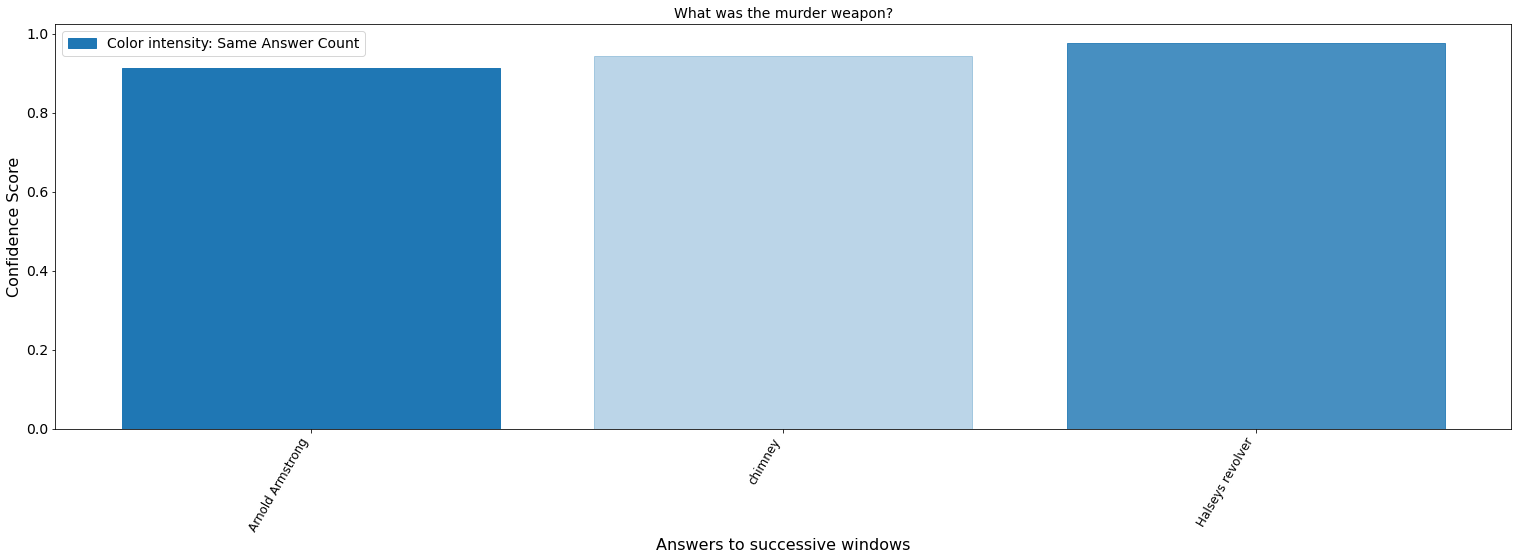

In [48]:
question = "What was the murder weapon?"
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'his  father', 'mean_score': 0.9675483107566833},
 {'answer': 'Anne Watson', 'mean_score': 0.9667791724205017},
 {'answer': 'Doctor  Walker', 'mean_score': 0.957973837852478},
 {'answer': 'Mrs.  Watson', 'mean_score': 0.951360821723938},
 {'answer': 'Beulah', 'mean_score': 0.9469619989395142},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9299119710922241},
 {'answer': 'stepbrother', 'mean_score': 0.8990408778190613},
 {'answer': 'Mr. Trautman', 'mean_score': 0.8782866597175598},
 {'answer': 'chimney', 'mean_score': 0.8270136415958405},
 {'answer': 'a member of the board', 'mean_score': 0.7831477522850037},
 {'answer': 'Fanny Armstrong', 'mean_score': 0.7722389400005341},
 {'answer': 'a son by  the first marriage', 'mean_score': 0.7469015717506409},
 {'answer': 'Mother', 'mean_score': 0.7296642661094666},
 {'answer': 'Doctor Stewarts', 'mean_score': 0.7253913879394531},
 {'answer': 'a member of  the volunteer company',
  'mean_score': 0.721871018409729}]


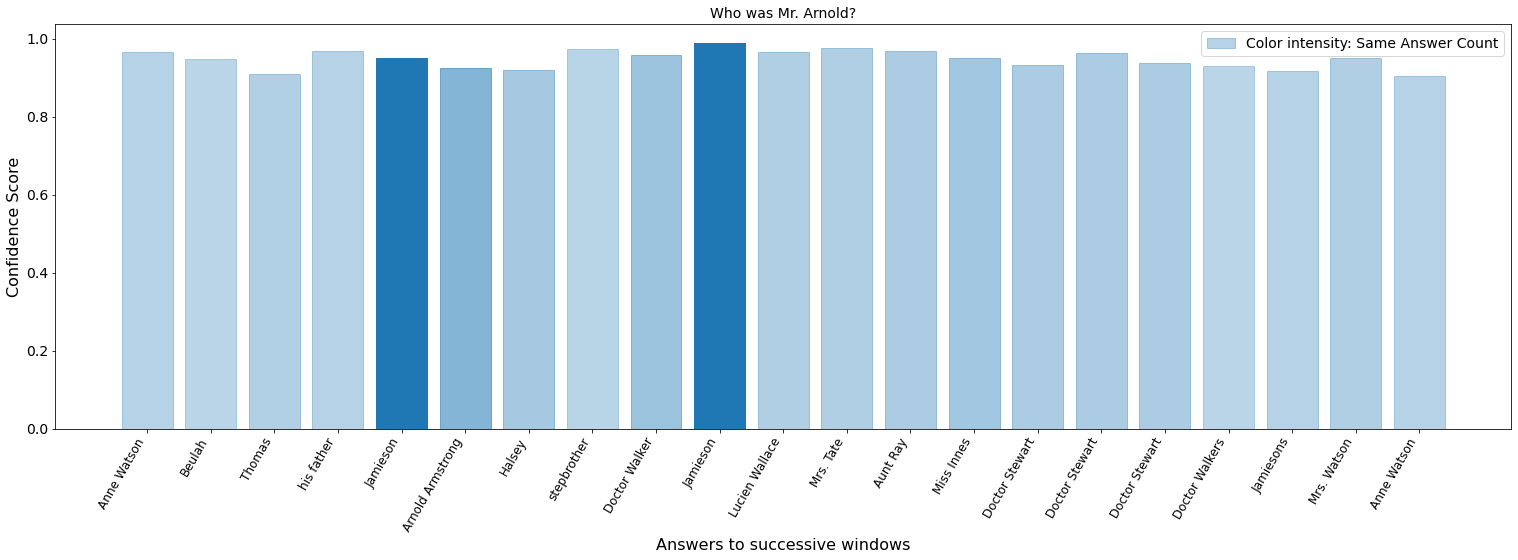

In [49]:
question = "Who was Mr. Arnold?"
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'Thomas Johnson', 'mean_score': 0.9966111183166504},
 {'answer': 'Mrs. Fitzhugh', 'mean_score': 0.9785282611846924},
 {'answer': 'Arnold  Armstrong', 'mean_score': 0.9615398049354553},
 {'answer': 'Doctor  Walker', 'mean_score': 0.9482490420341492},
 {'answer': 'Mrs.  Watson', 'mean_score': 0.9406408071517944},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9222699403762817},
 {'answer': 'Johnny Sweeny', 'mean_score': 0.9197875261306763},
 {'answer': 'Alex and Mr. Winters', 'mean_score': 0.8680903911590576},
 {'answer': 'the detective', 'mean_score': 0.8302044868469238},
 {'answer': 'Mrs. Tate', 'mean_score': 0.8173266723752022},
 {'answer': 'Sam  Bohannon and Warner', 'mean_score': 0.805915355682373},
 {'answer': 'the housekeeper', 'mean_score': 0.7980968356132507},
 {'answer': 'Paul  Armstrong', 'mean_score': 0.7849761247634888},
 {'answer': 'Doctor Stewart', 'mean_score': 0.7740903894106547},
 {'answer': 'Doctor  Stewart', 'mean_score': 0.7569206357002258}]


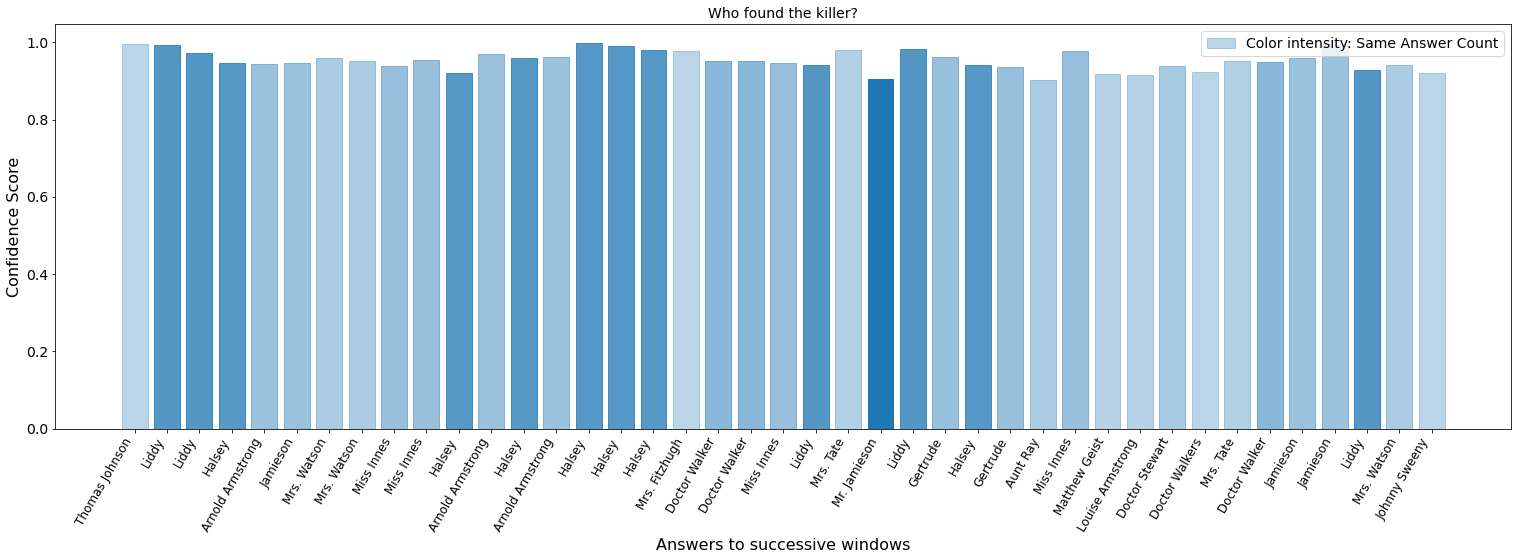

In [50]:
question = "Who found the killer?" 
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 0, end index 0 (0 sents used). Current length of text block: None:   0%|          | 0/328 [00:00<?, ?it/s]/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = 

[{'answer': 'Thomas Johnson', 'mean_score': 0.9713553388913473},
 {'answer': 'Mrs.  Watson', 'mean_score': 0.9620937705039978},
 {'answer': 'Doctor Walkers', 'mean_score': 0.9588878154754639},
 {'answer': 'Anne Watson', 'mean_score': 0.9474312663078308},
 {'answer': 'Liddys', 'mean_score': 0.9429296851158142},
 {'answer': 'Johnny Sweeny', 'mean_score': 0.9419068098068237},
 {'answer': 'Sam  Bohannon and Warner', 'mean_score': 0.9378312230110168},
 {'answer': 'Mr.  Jamieson', 'mean_score': 0.9308659434318542},
 {'answer': 'Mr. Aronson', 'mean_score': 0.910771369934082},
 {'answer': 'Doctor  Walker', 'mean_score': 0.9023255109786987},
 {'answer': 'Mr. Trautman', 'mean_score': 0.8916193246841431},
 {'answer': 'Anne  Watson', 'mean_score': 0.8720439672470093},
 {'answer': 'Jack Baileys', 'mean_score': 0.8596451282501221},
 {'answer': 'Doctor Stewart', 'mean_score': 0.8549106419086456},
 {'answer': 'Doctor  Stewart', 'mean_score': 0.8361791372299194}]


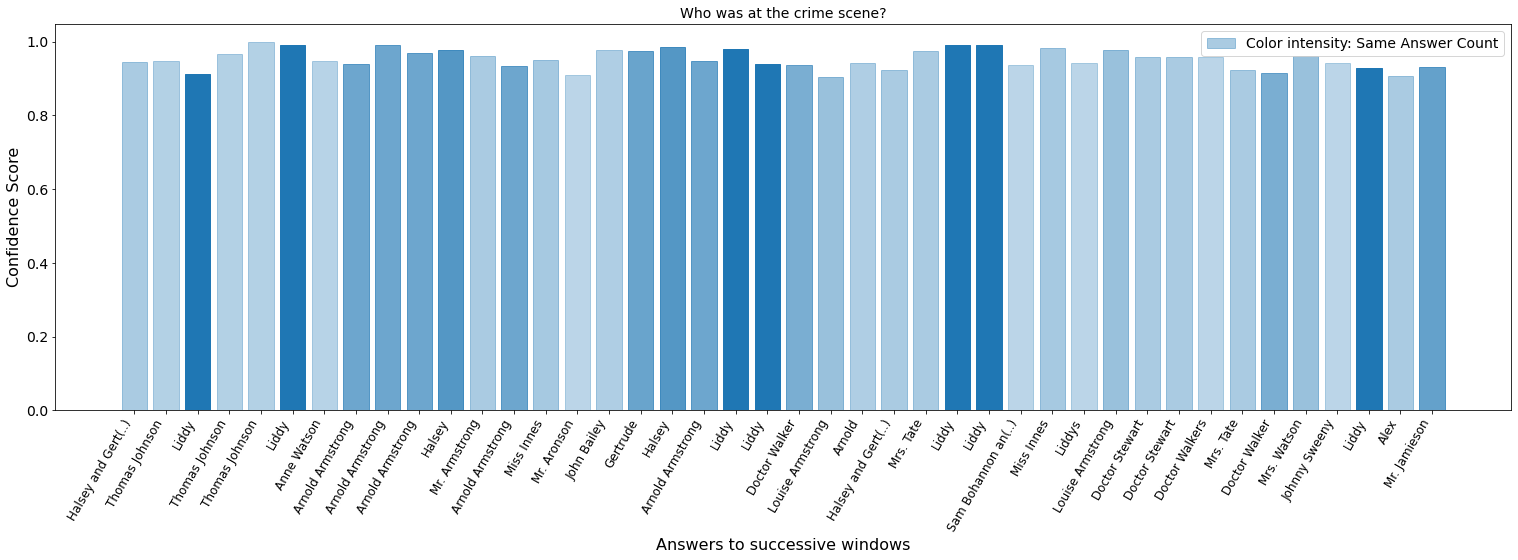

In [51]:
question = "Who was at the crime scene?" 
ask_question_of_whole_book(question, window)

Total number of sentences:  4908


Start index 4905, end index 4922 (17 sents used). Current length of text block: 262: 100%|██████████| 328/328 [00:33<00:00,  9.69it/s]


[{'answer': 'an hour and a half  ago', 'mean_score': 0.8732035756111145},
 {'answer': 'dawn', 'mean_score': 0.8312186598777771},
 {'answer': 'June the tenth', 'mean_score': 0.7696818113327026},
 {'answer': 'Until I am burned out', 'mean_score': 0.7315146625041962},
 {'answer': 'Monday  night', 'mean_score': 0.723377138376236},
 {'answer': 'Friday', 'mean_score': 0.7180528044700623},
 {'answer': 'Mother', 'mean_score': 0.6899242997169495},
 {'answer': 'six months', 'mean_score': 0.6801900267601013},
 {'answer': 'Monday evening', 'mean_score': 0.6777750179171562},
 {'answer': 'Sunday morning', 'mean_score': 0.6759719252586365},
 {'answer': 'Tuesday morning', 'mean_score': 0.6646909117698669},
 {'answer': 'Friday  night', 'mean_score': 0.6568309366703033},
 {'answer': 'Monday', 'mean_score': 0.6521300412714481},
 {'answer': 'when the train was moved', 'mean_score': 0.6499966382980347},
 {'answer': 'last summer', 'mean_score': 0.6117691397666931}]


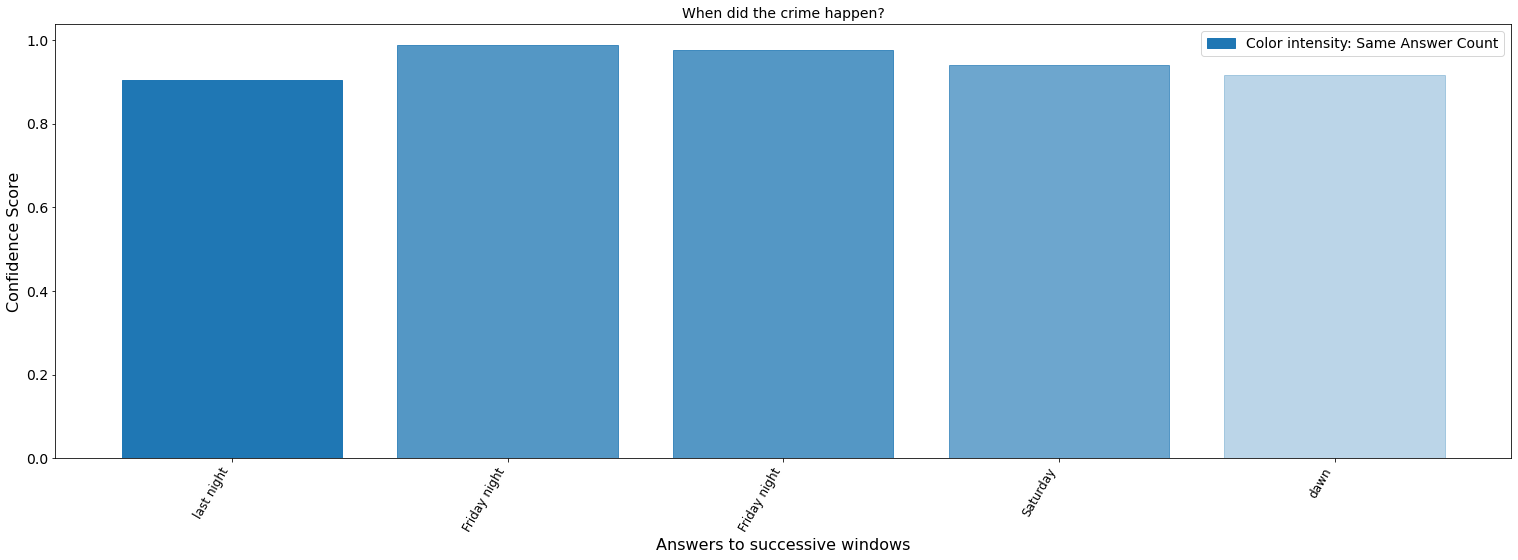

In [53]:
question = "When did the crime happen?" 
ask_question_of_whole_book(question, window)

## Part 2: Training our own

In [55]:
trainpath = 'squad/train-v2.0.json'
testpath = 'squad/dev-v2.0.json'
epochs = 5
learning_rate = 5e-5
proj3_lib.read_and_extract_train_val_data(trainpath, testpath, 
                                          question_contexts=total_contexts, 
                                          questions=total_questions, 
                                          answers=total_answers, 
                                          num_epochs=epochs, 
                                          lr=learning_rate)

Loading data
86821
86821
86821
86854
86854
86854
Tokenizing
Adding Token Positions
Converting to Torch Data
Creating Model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Using Device:  cuda
Creating Train Loader
Training


/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:705: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(
/gpfs/alpine/syb105/proj-shared/Personal/lanemj/environments/conda/transformers/lib/python3.8/site-package

Epoch Time:  1378.9905474185944
Epoch Time:  1378.880221605301
Epoch Time:  1379.553239107132
Epoch Time:  1379.3730919361115
Epoch Time:  1381.7603087425232
Total time:  6904.505823850632


(DistilBertForQuestionAnswering(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inplac

In [56]:
learning_rate = 1e-4
proj3_lib.read_and_extract_train_val_data(trainpath, testpath, 
                                          question_contexts=total_contexts, 
                                          questions=total_questions, 
                                          answers=total_answers, 
                                          num_epochs=epochs, 
                                          lr=learning_rate)

Loading data
86821
86821
86821
86854
86854
86854
Tokenizing
Adding Token Positions
Converting to Torch Data
Creating Model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Using Device:  cuda
Creating Train Loader
Training
Epoch Time:  1378.893042564392
Epoch Time:  1381.188371181488
Epoch Time:  1379.1299731731415
Epoch Time:  1380.2414512634277
Epoch Time:  1380.2854833602905
Total time:  6905.560189962387


(DistilBertForQuestionAnswering(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inplac

In [ ]:
learning_rate = 5e-4
proj3_lib.read_and_extract_train_val_data(trainpath, testpath, 
                                          question_contexts=total_contexts, 
                                          questions=total_questions, 
                                          answers=total_answers, 
                                          num_epochs=epochs, 
                                          lr=learning_rate)

Loading data
86821
86821
86821
86854
86854
86854
Tokenizing
Adding Token Positions
Converting to Torch Data
Creating Model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Using Device:  cuda
Creating Train Loader
Training
Epoch Time:  1378.175343990326
Epoch Time:  1377.003070116043
Epoch Time:  1378.2627263069153


In [98]:
import os 
learning_ratefile5e5 = "5e-05.tsv"
learning_ratefile1e4 = "0.0001.tsv"
learning_ratefile5e4 = "0.0005.tsv"

dflist = []


In [99]:
for file in os.listdir(): 
    if learning_ratefile5e5 in file or learning_ratefile1e4 in file or learning_ratefile5e4 in file: 
        df = pd.read_csv(file, sep='\t', index_col=0)
        dflist.append(df)

In [100]:
concatenated = pd.concat(dflist)

In [101]:
concatenated.reset_index(inplace=True)

In [102]:
import seaborn as sns

<AxesSubplot:xlabel='epoch', ylabel='score'>

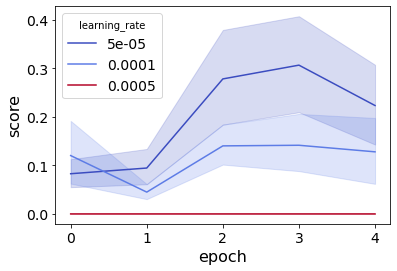

In [105]:
sns.lineplot(data=concatenated, x="epoch", y="score", hue='learning_rate', palette='coolwarm')
